# Project: Open Street Map Data Wrangling


## Table of Contents
<ul>
<li><a href="#area">Map Area</a></li>
<li><a href="#transf">Data Transformation</a></li>
<li><a href="#check">Data check and cleaning</a></li>
<li><a href="#overview">Data overview</a></li>
<li><a href="#better">How to get better data</a></li>
<li><a href="#explo">Data exploration</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='area'></a>
## Map Area

I chose the area of my hometown Hamburg as I am interested in the quality of the data I use daily for navigation purposes.
As I live a bit out of the city, I included my home area with the city Stade in my data extract.

Location:
- latitude 9.4235 - 10.3354
- longitude 53.3915 - 53.7422

Overpass Link: https://overpass-api.de/api/map?bbox=9.4235,53.3915,10.3354,53.7422

<br>

![Map Area](img/map_area.png)

<br> 

<a id='transf'></a>
## Data Transformation

I start by converting the data first into different csv files and then to an SQLite database as shown in the Nanodegree lessons. I had to adapt the code as I chose to use Python 3 (Python 2 is no longer supported since beginning of the year), the code I used is in the files xml_to_csv.py and csv_to_sql.py.

<a id='check'></a>
## Data check and cleaning

I started to do some queries on the database to get a feeling for the data. When checking the keys of the tag tables, I noticed that the addresses have not always been entered correctly, for example for the postal codes there were 4 different keys:
* addr:postcode
* postal_code
* postal_codes
* postcode

and some addresses were entered in only one tag with the key 'addr'.

The correct way to enter the address is described in the [OpenStreetMap Wiki](https://wiki.openstreetmap.org/wiki/Key:addr), so I will correct all addresses to match this.
Tags like 'addr:postcode' should be splitted to key 'postcode' and type 'addr' by the script, so here there seem to be more than two parts in the key of the tag. I checked the types of these keys:

```
select type, count(*) from nodes_tags where key='addr:postcode' group by type;
```
construction|1  
demolished|2  
memorial|1086

So there is more information mixed in these tags.


I want to include all extra information in the type and only have the last description in the key, so I will change the code so that it only uses the part after the last colon with using [rsplit](https://stackoverflow.com/questions/15012228/splitting-on-last-delimiter-in-python-string):
```
if ':' in key:
    tag_dict['key'] = key.rsplit(":", 1)[1]
    tag_dict['type'] = key.rsplit(":", 1)[0]
```
For the others, I added a dictionary to check for wrong writings and change the key:
```
BETTER_KEYS = {
        'postal_code': 'postcode',
        'postal_codes': 'postcode',
        'streetnumber': 'housenumber'
        }
```
In def handle_tags():
```
if tag_dict['key'] in BETTER_KEYS:
    tag_dict['key'] = BETTER_KEYS[tag_dict['key']]
```


There is one node with the keys 'housenumber_1' and 'street_1':
```
SELECT * FROM nodes_tags 
    JOIN (SELECT DISTINCT(id) FROM nodes_tags where key='housenumber_1') i
    ON nodes_tags.id=i.id;
```
4534983336|access|private|regular|4534983336  
4534983336|city|Hamburg|addr|4534983336  
4534983336|country|DE|addr|4534983336  
4534983336|housenumber|45a|addr|4534983336  
4534983336|housenumber_1|18|addr|4534983336  
4534983336|postcode|20355|addr|4534983336  
4534983336|street|Valentinskamp|addr|4534983336  
4534983336|street_1|Bäckerbreitergang|addr|4534983336  
4534983336|barrier|gate|regular|4534983336  
4534983336|entrance|yes|regular|4534983336  

As [discussed in the OSM Wiki](https://wiki.openstreetmap.org/wiki/Talk:Proposed_Features/addrN), there is no common way to enter two addresses for a node. It is only one node, so I will leave it as it is.

Now some tags have the key 'addr'.
In ways_tags, these are no addresses, but more comments: 
```
 select * from ways_tags where key='addr';
```
19750551|addr|http://www.luftwaffe.de/portal/poc/luftwaffe?uri=ci:bw.lw.org.ausb.uslw.kont|source  
25056340|addr|survey|source  
55131758|addr|dieses Gebäude hat tatsächlich die gleiche Hausnummer wie das vorne an der Straße, ist kein Fehler|note  
372297938|addr|380 steht am Eingang der Tankstelle|note

There is nothing important in these tags, so I can drop them.

For nodes_tags, it has the address in one value. I need to split these up in their parts and add a tag for each of these. There is not always all information included, so I need to find out which are there and which not. Some of them include a comma. If there is one, the first includes the street and sometimes the housenumber. The second one is the city and sometimes the postcode. If there is no comma, it is only the first part ( checked with `select * from nodes_tags where key='addr' and value not like '%,%';` ).
To check if housenumber or postcode are included, I will use RegEx. As some nodes have the address both in one and in more tags, I need to check to not make duplicates.
I wrote a new function for this: 
```
def split_address(tag_dict):
    '''
    splits one tag with key 'addr' in its single parts and creates a dict
    for each of them
    '''
    tags = []
    tag_dict['type'] = tag_dict['type'] + ':addr' # set tag type 
    addr_list = tag_dict['value'].split(',')
    # first: part one, street and housenumber
    if re.search(r'\d+', addr_list[0]) != None and ' ' in addr_list[0]: # checks if housenumber included and handles bad Unicode exception 
        # last part is housenumber, rest street
        housenumber = addr_list[0].rsplit(' ', 1)[1]
        housenumber_dict = tag_dict
        housenumber_dict['key'] = 'housenumber'
        housenumber_dict['value'] = housenumber
        if housenumber_dict not in tags: #check for duplicates
            tags.append(housenumber_dict)
                        
        street = addr_list[0].rsplit(' ', 1)[0]
        
    else:
        street = addr_list[0]
        if '/' in street:
            street = street.split('/')[0] # handles bad Unicode exception
        
    street_dict = tag_dict
    street_dict['key'] = 'street'
    street_dict['value'] = street
    if street_dict not in tags:
        tags.append(street_dict)
               
    if len(addr_list) == 2: # True when there has been a comma 
        if re.search(r'\d+', addr_list[1]) != None: # checks if postcode included
            # first part is postcode, second the city
            postcode = addr_list[1].split(' ', 1)[0]
            postcode_dict = tag_dict
            postcode_dict['key'] = 'postcode'
            postcode_dict['value'] = postcode
            if postcode_dict not in tags:
                tags.append(postcode_dict)
                        
            city = addr_list[1].rsplit(' ', 1)[1]
            
        else:
            city = addr_list[1]
        
        city_dict = tag_dict
        city_dict['key'] = 'city'
        street_dict['value'] = city
        if city_dict not in tags:
            tags.append(city_dict)
    return tags
``` 

With this code added, I update the csv's and the database.

<a id='overview'></a>
## Data overview





#### Data size

| File      | Size in MB |
| ----------- | ----------- |
| map_hamburg_stade.osm      | 1060       |
| nodes.csv   | 337        | 
| nodes_tags.csv   | 35        |
| ways.csv   | 45        |
| ways_nodes.csv   | 129        |
| ways_tags.csv   | 91       |
| OSM_Hamburg_Stade.   | 558  |


#### Number of nodes

```
sqlite> select count(*) from nodes;
```
4284263


#### Number of ways

```
sqlite> select count(*) from ways;
```
792954


#### Number of unique users

sqlite> select count(distinct(unionized.uid))          
from (select uid from nodes union all select uid from ways) as unionized;
5212


#### Top 10 contributing users

```
sqlite> select unionized.user, count(*)          
from (select user from nodes union all select user from ways) as unionized
group by unionized.user order by count (*) desc limit 10;
```

| Username      | Contributions |
| ----------- | ----------- |
|svbr|292169|
|4Ems|217762|
|Abendstund|202924|
|ma-rt-in|196830|
|jbhh12|158875|
|fahrrad|158205|
|vademecum|141330|
|streele|136943|
|sundew|136445|
|simlox|132451|



#### Number of users appearing only once (having 1 post)
```
sqlite> select count(*) FROM
	(select unionized.user, count(*)          
	from (select user from nodes union all select user from ways) as unionized
	group by unionized.user having count(*)=1)
;
```
1102

<a id='better'></a>
## How to get better data

As the top contributing user made only ca. 6 % of all contributions, there seem to be many big contributors for this area, but there are also many contributors making only one contribution. 
In the data cleaning, it was obvious that some data is already available, but formatted wrong. To get an improvement here, I think it would help to have an automated checking of the data and then providing suggestions to users where they can check and correct data. Also missing data could be included here if there is obviously or maybe something missing.
With this, one-time users could be encouraged to continue with contributions if the editor provides them with suggestions what to check in the vicinity of their already made contribution(s). 

Furthermore, I think the android app [Vespucci](https://wiki.openstreetmap.org/wiki/Vespucci) should be advertised more prominently as you can use this on the go, so you can walk around and directly editing the data you are literally standing on. Here it would also be good to show corrupted or missing data directly in the map so I can go there and have a look for the reality.

The problem with showing problematic or missing data is that not all problems are detectable automatically as there are mistakes not visible in data structure. These will go unnoticed. 
Another point is that sometimes the world does not fit in a clearly defined structure and there will be data outside of normality that is indeed correct. With an automated problem finder, this will always be marked as a mistake where it is not.
Also with the worldwide target group of OSM, language and culture difficulties come up (addresses are noted different ways in different countries), so the problem finder system will be immensely difficult.
This shows that it should definitely not correct the findings automatically, there should always be a human involved. Also, be aware that not all findings will be mistakes and not all mistakes will be findings.

<a id='explo'></a>
## Data Exploration

#### Spreading of defibrillators in the city

In [1]:
import sqlite3, pandas, matplotlib.pyplot as plt, seaborn as sns
db = sqlite3.connect("OSM_Hamburg_Stade.db")

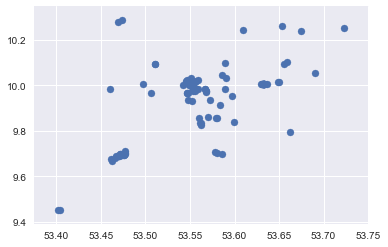

In [2]:
query = "select nodes.id, nodes.lat, nodes.lon from nodes_tags, nodes where nodes_tags.id = nodes.id and nodes_tags.value='defibrillator';"

defibrillators_df = pandas.read_sql(query, db)
% matplotlib inline
plt.scatter(x = defibrillators_df['lat'], y= defibrillators_df['lon'])

The distribution of defibrillators seems rather skewed as there are large areas without any. I don't think this projects reality as most smaller villages get a defibrillator in public buildings. Here seems to be data missing. I think this is critical data as in an emergency, a life can depend on if a person finds the next defibrillator or not. 
If this is indeed reality, there should be more defibrillators regularly distributed.

#### Top 5 shops

```
select value, count(*) from nodes_tags where key='shop' group by value order by count(*) desc limit 5;
```
| Kind of shop | number of occurences | 
|---|---|
|hairdresser|928| 
|clothes|923| 
|bakery|842| 
|supermarket|568| 
|kiosk|471| 

People in this area seem to have a really strong hairgrowth.

#### Accessibility of toilets

```
select nodes_tags.value, count(*) from nodes_tags 
    join (select distinct(id) from nodes_tags where key='toilets') reduced
    ON nodes_tags.id=reduced.id
where nodes_tags.key ='wheelchair'
group by nodes_tags.value order by count(*) desc;
```

| Wheelchair accessible | number of occurences | 
|---|---|
|yes|27|
|limited|10|
|no|10|
|designated|1|

There are not many toilets marked as wheelchair accessible or not. This could be better to provide a chance to find accessible toilets for wheelchair users.

<a id='conclusions'></a>
## Conclusions

There is much information in Openstreetmap data and it is very good to work with. Unfortunately part of the data is not in a good shape and needs to be cleaned. Here, automatized checks could help a lot to show corrupt data and find missing information. The user should be helped by software.

In [3]:
db.close()